### 해야할 것들

1. Efficient Net 0
2. Efficient Net 1
3. Efficient Net 2 
4. MobileNet V2
5. MobileNet V3

각 모델들 데이터 전처리, 정규화, 학습 진행하고 안드로이드에 붙여보기

In [1]:
import matplotlib.pylab as plt
import os
import datetime
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.layers import Flatten, Dense
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except RuntimeError as e:
    print("error",e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_root = 'C:/Users/Etri/Desktop/eunsoo/images'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'validation')

In [4]:
data_root = 'C:/Users/Etri/Desktop/eunsoo/images'
batch_size = 32
img_height = 224
img_width = 224
image_shape = (img_width, img_height)
labels = ['Chat', 'noneChat']

num_epochs = 10

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [5]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Chat' 'noneChat']


In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 7
Number of test batches: 6


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [10]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [13]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    callbacks=tensorboard_callback)

Epoch 1/10
50/50 [==============================] - 6s 63ms/step - loss: 0.4591 - accuracy: 0.7956 - val_loss: 0.2500 - val_accuracy: 0.9423
Epoch 2/10
50/50 [==============================] - 2s 41ms/step - loss: 0.2163 - accuracy: 0.9550 - val_loss: 0.1615 - val_accuracy: 0.9663
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1471 - accuracy: 0.9781 - val_loss: 0.1264 - val_accuracy: 0.9663
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1130 - accuracy: 0.9819 - val_loss: 0.1065 - val_accuracy: 0.9712
Epoch 5/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0919 - accuracy: 0.9850 - val_loss: 0.0932 - val_accuracy: 0.9712
Epoch 6/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0774 - accuracy: 0.9894 - val_loss: 0.0836 - val_accuracy: 0.9712
Epoch 7/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0668 - accuracy: 0.9906 - val_loss: 0.0761 - val_accuracy: 0.9712
Epoch 8/10
50

In [14]:
loss, accuracy = model.evaluate(test_ds)

6/6 [==============================] - 1s 42ms/step - loss: 0.0609 - accuracy: 0.9792


In [15]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16208), started 4:23:43 ago. (Use '!kill 16208' to kill it.)

In [16]:
def isHalf(batch):
    id_list = []
    for i in batch:
        if (i < 0.5):
            id_list.append('Chat')
        else:
            id_list.append('noneChat')
    return id_list

predicted_batch = model.predict(image_batch)
predicted_id = isHalf(predicted_batch)
print(predicted_id)

1/1 [==============================] - 0s 380ms/step
['noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'Chat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat']


In [17]:
def labelsCompare(batch):
    label_list = []
    for i in batch:
        if(i == 1):
            label_list.append('noneChat')
        else:
            label_list.append('Chat')
    return label_list

label_numpy = labels_batch.numpy() #Tensor to numpy (list로 쓰기 위해)
label_id = labelsCompare(label_numpy)
print(label_id)

['noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'Chat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat']


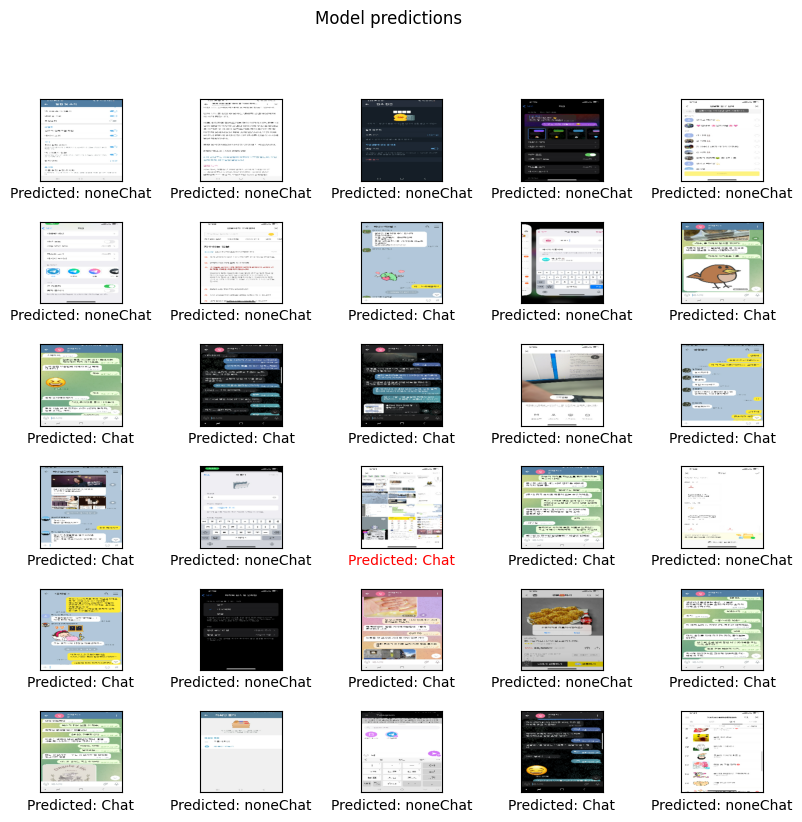

In [18]:
#라벨 맞는지 아닌지 글자색으로 표시해주는 함수
def get_label_color(val1, val2):
    if val1 == val2:
        return 'black' #맞으면 블랙
    else:
        return 'red' #아니면 레드

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    ax = plt.subplot(6,5,n+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[n])
    color = get_label_color(predicted_id[n],
                label_id[n])
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predicted_id[n])
    _ = plt.suptitle("Model predictions")

In [19]:
ver = '3'

# 이름 꼭 바꿔주기!!!!!!
model_name = 'mobilenet'
path = 'C:/Users/Etri/Desktop/eunsoo/models/mobilenet/'
model.save(path+ver+'.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open(path+model_name+ver+'.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Etri\AppData\Local\Temp\tmp_0yj70jn\assets


INFO:tensorflow:Assets written to: C:\Users\Etri\AppData\Local\Temp\tmp_0yj70jn\assets


In [ ]:
interpreter = tf.lite.Interpreter(model_path=path+model_name+ver+'.tflite')
interpreter.allocate_tensors()

input_data = interpreter.get_input_details()[0]
output_data = interpreter.get_output_details()[0]

In [ ]:
print('input_data', input_data)
print('\n========================================================================================\noutput_data',output_data)

In [ ]:
def test_tflite_model(tflite_path, images):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    # 입력 텐서 정보 : 인덱스를 알아야 데이터를 전달할 수 있다.
    input_details = interpreter.get_input_details()
    # index 0,

    # 출력 텐서 정보 : 인덱스를 알아야 결과를 받아올 수 있다.
    output_details = interpreter.get_output_details()
    # index 285, 

    result = []
    for img_path in images:
        input_data = load_image(img_path, scaling=True)
        input_data = input_data[np.newaxis]

        # 입력 데이터 전달
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # 출력 데이터 읽기
        output_data = interpreter.get_tensor(output_details[0]['index'])
        result.append(output_data)

    # 1차원 변환 출력
    print(np.reshape(result, -1))


# 텐서플로 라이트 모델 경로와 시험할 사진 경로 전달
test_tflite_model('models/cats_and_dogs.tflite', images)